# Experimento 1

[CNN] Epoch 1/5 | Loss: 0.1378
[CNN] Epoch 2/5 | Loss: 0.0292
[CNN] Epoch 3/5 | Loss: 0.0515
[CNN] Epoch 4/5 | Loss: 0.0084
[CNN] Epoch 5/5 | Loss: 0.0720


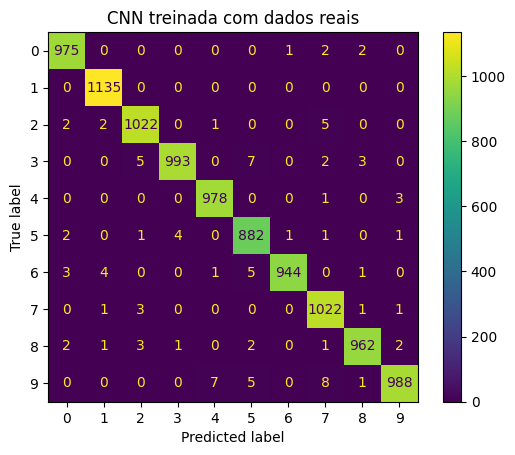

In [ ]:
# =========================================================
# main_experimento1.py
# Script principal experimento 1 e
# 1) CARREGA OS DADOS
# 2) TREINA UMA CNN SOBRE DAOOS REAIS
# 3) TESTA A CNN SOBRE DADOS REAIS
# =========================================================

import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

# Importa modelos
from models import (
    CNNClassifier,
    ConditionalGenerator,
    ConditionalDiscriminator
)

# Importa rotinas de treinamento
from training import (
    train_classifier,
    train_cgan,
    plot_confusion,
    compute_statistics,
    calculate_fid
)

# =========================================================
# CONFIGURAÇÃO
# =========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

# =========================================================
# DATASET MNIST
# =========================================================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(
    "./data", train=True, download=True, transform=transform
)

test_dataset = datasets.MNIST(
    "./data", train=False, download=True, transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# =========================================================
# TREINAMENTO DE UMA CNN COM DADOS REAIS
# =========================================================
cnn_real = CNNClassifier().to(device)
train_classifier(cnn_real, train_loader, device)


# Faz o gráfico da matriz de confusão
plot_confusion(cnn_real, test_loader, device,
               "CNN treinada com dados reais")

In [4]:
# =========================================================
# main_experimento1_variacoes.py
# Experimento 1 — Variações de Arquitetura e Hiperparâmetros
#
# Atividades do aluno:
# - Variar número de camadas convolucionais
# - Alterar número de filtros
# - Comparar taxas de aprendizado
# - Avaliar impacto do número de épocas
# =========================================================

import inspect
from models_experimento1 import CNNClassifier


import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Importa modelos (CNN parametrizada)
from models_experimento1 import CNNClassifier

# Importa rotinas de treinamento
from training import train_classifier, plot_confusion

# =========================================================
# CONFIGURAÇÃO
# =========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

# =========================================================
# DATASET MNIST
# =========================================================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(
    "./data", train=True, download=True, transform=transform
)

test_dataset = datasets.MNIST(
    "./data", train=False, download=True, transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# =========================================================
# FUNÇÃO DE AVALIAÇÃO (ACURÁCIA)
# =========================================================
def evaluate_accuracy(model, loader, device):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    return correct / total


# =========================================================
# LISTA PARA ARMAZENAR RESULTADOS
# =========================================================
results = []

# =========================================================
# 1) VARIAR NÚMERO DE CAMADAS CONVOLUCIONAIS
# =========================================================
configs_convs = [
    {"n_convs": 1, "filters": (32,)},
    {"n_convs": 2, "filters": (32, 64)},          # baseline
    {"n_convs": 3, "filters": (32, 64, 128)}
]

print("\n=== VARIAÇÃO DO NÚMERO DE CAMADAS ===")

for cfg in configs_convs:
    print(f"\nCamadas: {cfg['n_convs']} | Filtros: {cfg['filters']}")

    model = CNNClassifier(
        n_convs=cfg["n_convs"],
        filters=cfg["filters"]
    ).to(device)

    train_classifier(model, train_loader, device, epochs=10)
    acc = evaluate_accuracy(model, test_loader, device)

    results.append(("Camadas", cfg, acc))
    print(f"Acurácia: {acc:.4f}")


# =========================================================
# 2) VARIAR NÚMERO DE FILTROS (2 CAMADAS FIXAS)
# =========================================================
configs_filters = [
    (16, 32),
    (32, 64),     # baseline
    (64, 128)
]

print("\n=== VARIAÇÃO DO NÚMERO DE FILTROS ===")

for filters in configs_filters:
    print(f"\nFiltros: {filters}")

    model = CNNClassifier(
        n_convs=2,
        filters=filters
    ).to(device)

    train_classifier(model, train_loader, device, epochs=10)
    acc = evaluate_accuracy(model, test_loader, device)

    results.append(("Filtros", filters, acc))
    print(f"Acurácia: {acc:.4f}")


# =========================================================
# 3) VARIAR TAXA DE APRENDIZADO
# =========================================================
learning_rates = [1e-2, 1e-3, 1e-4]

print("\n=== VARIAÇÃO DA TAXA DE APRENDIZADO ===")

for lr in learning_rates:
    print(f"\nLearning Rate: {lr}")

    model = CNNClassifier().to(device)

    train_classifier(
        model,
        train_loader,
        device,
        epochs=10,
        lr=lr
    )

    acc = evaluate_accuracy(model, test_loader, device)
    results.append(("Learning Rate", lr, acc))

    print(f"Acurácia: {acc:.4f}")


# =========================================================
# 4) VARIAR NÚMERO DE ÉPOCAS
# =========================================================
epochs_list = [5, 10, 20]

print("\n=== VARIAÇÃO DO NÚMERO DE ÉPOCAS ===")

for ep in epochs_list:
    print(f"\nÉpocas: {ep}")

    model = CNNClassifier().to(device)

    train_classifier(
        model,
        train_loader,
        device,
        epochs=ep
    )

    acc = evaluate_accuracy(model, test_loader, device)
    results.append(("Épocas", ep, acc))

    print(f"Acurácia: {acc:.4f}")


# =========================================================
# RESUMO FINAL
# =========================================================
print("\n=== RESUMO DOS RESULTADOS ===")
for r in results:
    print(r)


# =========================================================
# MATRIZ DE CONFUSÃO DO BASELINE
# =========================================================
print("\n=== MATRIZ DE CONFUSÃO — BASELINE ===")

baseline_model = CNNClassifier(
    n_convs=2,
    filters=(32, 64)
).to(device)

train_classifier(baseline_model, train_loader, device, epochs=10)

plot_confusion(
    baseline_model,
    test_loader,
    device,
    "CNN Baseline — 2 camadas (32, 64)"
)



=== VARIAÇÃO DO NÚMERO DE CAMADAS ===

Camadas: 1 | Filtros: (32,)
[CNN] Epoch 1/10 | Loss: 0.1012
[CNN] Epoch 2/10 | Loss: 0.0851
[CNN] Epoch 3/10 | Loss: 0.1045
[CNN] Epoch 4/10 | Loss: 0.0122
[CNN] Epoch 5/10 | Loss: 0.0197
[CNN] Epoch 6/10 | Loss: 0.0454
[CNN] Epoch 7/10 | Loss: 0.0091
[CNN] Epoch 8/10 | Loss: 0.0354
[CNN] Epoch 9/10 | Loss: 0.0373
[CNN] Epoch 10/10 | Loss: 0.0035
Acurácia: 0.9857

Camadas: 2 | Filtros: (32, 64)
[CNN] Epoch 1/10 | Loss: 0.0287
[CNN] Epoch 2/10 | Loss: 0.0317
[CNN] Epoch 3/10 | Loss: 0.0422
[CNN] Epoch 4/10 | Loss: 0.0680
[CNN] Epoch 5/10 | Loss: 0.0086
[CNN] Epoch 6/10 | Loss: 0.0054
[CNN] Epoch 7/10 | Loss: 0.0100
[CNN] Epoch 8/10 | Loss: 0.0061
[CNN] Epoch 9/10 | Loss: 0.0018
[CNN] Epoch 10/10 | Loss: 0.0035
Acurácia: 0.9924

Camadas: 3 | Filtros: (32, 64, 128)
[CNN] Epoch 1/10 | Loss: 0.1386
[CNN] Epoch 2/10 | Loss: 0.0427
[CNN] Epoch 3/10 | Loss: 0.0286
[CNN] Epoch 4/10 | Loss: 0.0165
[CNN] Epoch 5/10 | Loss: 0.0184
[CNN] Epoch 6/10 | Loss: 0.

KeyboardInterrupt: 

In [1]:
# =========================================================
# models.py
# Contém apenas definições de ARQUITETURA CNN e cGANs
# Para cGANS utiliza uma MLP
# (nenhum treinamento aqui)
# =========================================================

# Importa o PyTorch base
import torch

# Importa o módulo de redes neurais
import torch.nn as nn

# =========================================================
# CNN CLASSIFICADORA PARA MNIST (PARAMETRIZADA)
# =========================================================
class CNNClassifier(nn.Module):
    """
    CNN simples usada para:
    - Classificação com dados reais
    - Classificação com dados fake gerados pela cGAN

    Parâmetros:
    - n_convs: número de camadas convolucionais
    - filters: tupla com o número de filtros por camada
    """

    def __init__(self, n_convs=2, filters=(32, 64)):
        super().__init__()

        assert n_convs == len(filters), \
            "n_convs deve ser igual ao tamanho de filters"

        # -------------------------
        # Extrator de características
        # -------------------------
        layers = []
        in_channels = 1
        current_size = 28  # tamanho inicial da imagem MNIST

        for i in range(n_convs):
            layers.append(
                nn.Conv2d(in_channels, filters[i], kernel_size=3)
            )
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(2))

            in_channels = filters[i]
            current_size = (current_size - 2) // 2  # conv 3x3 + pool 2x2

        self.features = nn.Sequential(*layers)

        # -------------------------
        # Classificador totalmente conectado
        # -------------------------
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_channels * current_size * current_size, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        """
        Define o fluxo forward da CNN
        """
        x = self.features(x)
        x = self.classifier(x)
        return x


# =========================================================
# GERADOR CONDICIONAL (cGAN)
# =========================================================
class ConditionalGenerator(nn.Module):
    """
    Gerador da cGAN:
    Entrada:
      - vetor de ruído z
      - rótulo y
    Saída:
      - imagem 28x28 condicionada ao rótulo
    """

    def __init__(self, z_dim=100, n_classes=10):
        super().__init__()

        self.label_emb = nn.Embedding(
            num_embeddings=n_classes,
            embedding_dim=n_classes
        )

        self.net = nn.Sequential(
            nn.Linear(z_dim + n_classes, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Tanh()
        )

    def forward(self, z, y):
        y_emb = self.label_emb(y)
        x = torch.cat([z, y_emb], dim=1)
        img = self.net(x).view(-1, 1, 28, 28)
        return img


# =========================================================
# DISCRIMINADOR CONDICIONAL (cGAN)
# =========================================================
class ConditionalDiscriminator(nn.Module):
    """
    Discriminador da cGAN:
    Entrada:
      - imagem
      - rótulo
    Saída:
      - probabilidade de ser real
    """

    def __init__(self, n_classes=10):
        super().__init__()

        self.label_emb = nn.Embedding(
            num_embeddings=n_classes,
            embedding_dim=784
        )

        self.net = nn.Sequential(
            nn.Linear(784 * 2, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x, y):
        x = x.view(x.size(0), -1)
        y_emb = self.label_emb(y)
        d_input = torch.cat([x, y_emb], dim=1)
        out = self.net(d_input)
        return out


In [2]:
# =========================================================
# training.py
# Contém rotinas de treinamento e métricas
# =========================================================

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy import linalg
import matplotlib.pyplot as plt


# =========================================================
# TREINAMENTO DA CNN
# =========================================================
def train_classifier(model, loader, device, epochs=5):
    """
    Treina uma CNN supervisionada
    """

    # Coloca o modelo em modo treino
    model.train()

    # Otimizador Adam
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Função de perda multiclasse
    criterion = nn.CrossEntropyLoss()

    # Loop de épocas
    for epoch in range(epochs):

        # Loop sobre batches
        for x, y in loader:

            # Move dados para GPU/CPU
            x, y = x.to(device), y.to(device)

            # Zera gradientes acumulados
            optimizer.zero_grad()

            # Forward pass
            logits = model(x)

            # Calcula perda
            loss = criterion(logits, y)

            # Backpropagation
            loss.backward()

            # Atualiza pesos
            optimizer.step()

        print(f"[CNN] Epoch {epoch+1}/{epochs} | Loss: {loss.item():.4f}")


# =========================================================
# MATRIZ DE CONFUSÃO
# =========================================================
def plot_confusion(model, loader, device, title):
    """
    Calcula e plota a matriz de confusão
    """

    # Modo avaliação
    model.eval()

    y_true, y_pred = [], []

    # Sem gradientes
    with torch.no_grad():
        for x, y in loader:

            x = x.to(device)

            # Predição
            preds = model(x).argmax(dim=1).cpu()

            y_true.extend(y.numpy())
            y_pred.extend(preds.numpy())

    # Matriz de confusão
    cm = confusion_matrix(y_true, y_pred)

    # Visualização
    ConfusionMatrixDisplay(cm).plot()
    plt.title(title)
    plt.show()


# =========================================================
# TREINAMENTO DA cGAN
# =========================================================
def train_cgan(G, D, loader, device, epochs=20, z_dim=100):
    """
    Treina uma cGAN (gerador + discriminador)
    """

    # Otimizadores
    opt_g = optim.Adam(G.parameters(), lr=2e-4)
    opt_d = optim.Adam(D.parameters(), lr=2e-4)

    # Perda adversarial
    criterion = nn.BCELoss()

    for epoch in range(epochs):
        for x, y in loader:

            x, y = x.to(device), y.to(device)
            batch = x.size(0)

            # ======================
            # Treina Discriminador
            # ======================
            z = torch.randn(batch, z_dim, device=device)

            fake = G(z, y)

            loss_d = (
                criterion(D(x, y), torch.ones(batch, 1, device=device)) +
                criterion(D(fake.detach(), y),
                          torch.zeros(batch, 1, device=device))
            )

            opt_d.zero_grad()
            loss_d.backward()
            opt_d.step()

            # ======================
            # Treina Gerador
            # ======================
            z = torch.randn(batch, z_dim, device=device)

            fake = G(z, y)

            loss_g = criterion(
                D(fake, y),
                torch.ones(batch, 1, device=device)
            )

            opt_g.zero_grad()
            loss_g.backward()
            opt_g.step()

        print(f"[cGAN] Epoch {epoch+1}/{epochs} | "
              f"D: {loss_d.item():.4f} | G: {loss_g.item():.4f}")


# =========================================================
# FID
# =========================================================
def compute_statistics(loader, extractor, device):
    """
    Calcula média e covariância das features
    """

    features = []

    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            features.append(extractor(x).cpu().numpy())

    features = np.concatenate(features)

    return np.mean(features, axis=0), np.cov(features, rowvar=False)


def calculate_fid(mu1, sigma1, mu2, sigma2):
    """
    Calcula Fréchet Inception Distance
    """
    diff = mu1 - mu2
    covmean = linalg.sqrtm(sigma1 @ sigma2)



    # Correção numérica (parte imaginária pequena)
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff @ diff + np.trace(sigma1 + sigma2 - 2 * covmean)

    return fid